# Introduction
In this demonstration, we will implement an convolutional variational autoencoder (c-VAE or just VAE) to generate random new realistic images of clothing apparels by training it on the fashion-MNIST dataset from `keras`. The objective of this demonstration is to motivate the importance of latent spaces and how they can be used to generate new images.

Please note that we have taken reference from the code made available by [*fchollet*](https://twitter.com/fchollet).

## Setup
Let us import the necessary packages and methods for this demonstration:
- Working with numeric structures: `numpy`
- Working with images: `matplotlib.pyplot`
- Working with artificial neural networks: `tensorflow`, `keras`

In [ ]:
# Load necessary methods and packages
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

## Data
Let us load the fashion-MNIST dataset and study the images that we are working with.

In [ ]:
# Import the 'fashion_mnist' data package from 'keras'
from keras.datasets import fashion_mnist

# Load the data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Undo the train-test split
X = np.concatenate([X_train, X_test], axis = 0)
y = np.concatenate([y_train, y_test])

# Normalize the pixel gray levels
X = np.expand_dims(X, -1).astype('float32') / 255

VAEs are used for random image generation and hence follow a different training regime. Because of this, we have the following considerations:
- We do not need the $y$ values that are generally used for classification
- We do not need a train-test split

**Note:** We will use the $y$ values later for some analysis, so we are retaining them.

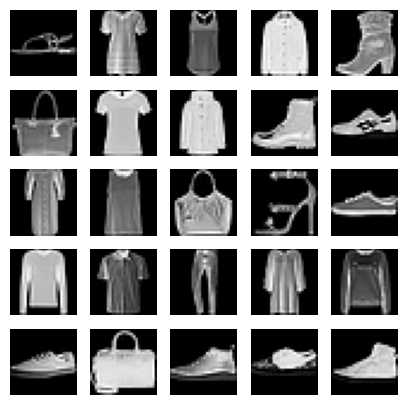

In [ ]:
# Sample a few fashion MNIST images from the data and view the images
indices = np.random.randint(0, X.shape[0], size = 25)

images = X[indices]

plt.figure(figsize = (5, 5))

for i in np.arange(0, len(indices), 1):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')

You can see that the fashion-MNIST data are grayscale images of size 28x28 of various clothing apparels such as shoes, shirts, and so on.

In [ ]:
# Study the shape of the data
print('Data shape: ', X.shape) # (70000, 28, 28, 1) --- 70000 images, each 28x28 pixels

Data shape:  (70000, 28, 28, 1)


# Part 1 - Building the VAE
In this section, we will construct the components of the VAE and combine them into a single VAE model. Note that the VAE is primarily comprised of three major components:
- Sampler
- Encoder
- Decoder

### Sampler
The purpose of the sampling layer is to generate a random (noise) vector belonging to the latent space.

In [ ]:
# Define the sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        # Obtain the mean and variance of latent space vectors from previous layers
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        # Introduce slight variations in the latent vector
        epsilon = tf.random.normal(shape = (batch, dim))

        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder
The encoder converts the original images into smaller latent space vectors and learns the transformation function.

In [ ]:
# print("Input Image:")
# #image = load_png("image.png")
# # Print input image plt.imshow(image)
# print("Input shape:")
# print(image.shape)


In [ ]:
# latent = vae.encoder(image)
# print("Latent vector:", latent)
# print("Shape of latent vector:", latent.shape)

In [ ]:
# Choose the dimensionality of your latent space
latent_dim = 2

# Specify the input data shape
encoder_inputs = keras.Input(shape = (28, 28, 1))

# Add a convolutional layer
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', strides = 2, padding = 'same')(encoder_inputs)

# Add a convolutional layer
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', strides = 2, padding = 'same')(x)

# Flatten the feature map into a 1D array
x = layers.Flatten()(x)

# Add a dense layer
x = layers.Dense(units = 16, activation = 'relu')(x)

# Add computational layers to obtain the mean and variance of the vectors in the latent space
z_mean = layers.Dense(units = latent_dim, name = 'z_mean')(x)
z_log_var = layers.Dense(units = latent_dim, name = 'z_log_var')(x)

# Add a sampling layer
z = Sampling()([z_mean, z_log_var])

# Combine all the layers into a single model
encoder = keras.Model(inputs = encoder_inputs, outputs = [z_mean, z_log_var, z], name = 'encoder')

# Look at a summary of the encoder
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 14, 14, 32)           320       ['input_5[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_4[0][0]']            
                                                                                                  
 flatten_2 (Flatten)         (None, 3136)                 0         ['conv2d_5[0][0]']            
                                                                                            

### Decoder
The decoder converts the latent space vector into the original image space and learns the transformation.

In [ ]:
# Specify the shape of the input to the decoder
latent_inputs = keras.Input(shape = (latent_dim, ))

# Add a dense layer
x = layers.Dense(units = 7 * 7 * 64, activation = 'relu')(latent_inputs)

# Add a reshaping layer
x = layers.Reshape((7, 7, 64))(x)

# Add a transpose convolutional layer
x = layers.Conv2DTranspose(filters = 64, kernel_size = 3, activation = 'relu', strides = 2, padding = 'same')(x)

# Add another tranpose convolutional layer
x = layers.Conv2DTranspose(filters = 32, kernel_size = 3, activation = 'relu', strides = 2, padding = 'same')(x)

# Add an output transpose convolutional layer
decoder_outputs = layers.Conv2DTranspose(filters = 1, kernel_size = 3, activation = 'sigmoid', padding = 'same')(x)

# Combine all the layers into a single model
decoder = keras.Model(inputs = latent_inputs, outputs = decoder_outputs, name = 'decoder')

# Look at a summary of the encoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 28, 28, 1)         289 

### VAE
We will now put together the sampler, encoder and decoder into a single VAE model and define its training process.

In [ ]:
# Create a new model class and define the VAE with a custom training step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)

        # Add the encoder and decoder to the model
        self.encoder = encoder
        self.decoder = decoder

        # Define various loss metrics required for training
        self.total_loss_tracker = keras.metrics.Mean(name = 'total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = 'reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name = 'kl_loss')

    # Create property attribute to return the loss values
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    # Describe the parameter update process based on the loss values
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Obtain a random vector from the latent space
            z_mean, z_log_var, z = self.encoder(data)

            # Generate an image using the random vector
            reconstruction = self.decoder(z)

            # Calculate the losses
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis = (1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            total_loss = reconstruction_loss + kl_loss

        # Update parameters and loss atteributes
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Return the loss values
        return {'loss': self.total_loss_tracker.result(),
                'reconstruction_loss': self.reconstruction_loss_tracker.result(),
                'kl_loss': self.kl_loss_tracker.result()}

Now that the VAE model is well defined, let us compile it and ensure that it is ready to be trained.

In [ ]:
# Initialize an instance of a VAE and compile the model
# Note: We can use the Adam optimizer and set its learning rate for better results
vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0005))

# Part 2 - Training the VAE
In this section, we will train the VAE.

In [ ]:
# Train the VAE for a number of epochs for a particular batch size
vae.fit(X, epochs = 5, batch_size = 256)

Epoch 1/5
274/274 [==============================] - 98s 346ms/step - loss: 433.8889 - reconstruction_loss: 371.8308 - kl_loss: 6.4692
Epoch 2/5
274/274 [==============================] - 92s 337ms/step - loss: 313.7198 - reconstruction_loss: 295.9944 - kl_loss: 11.1251
Epoch 3/5
274/274 [==============================] - 91s 330ms/step - loss: 294.1451 - reconstruction_loss: 281.2637 - kl_loss: 9.4759
Epoch 4/5
274/274 [==============================] - 92s 336ms/step - loss: 283.7027 - reconstruction_loss: 273.7500 - kl_loss: 7.8751
Epoch 5/5
274/274 [==============================] - 90s 330ms/step - loss: 277.8864 - reconstruction_loss: 269.7017 - kl_loss: 7.1431


# Part 3 - Generating Images
In this section, we will use the trained VAE to generate new images using latent space vectors.

### Generating images from the latent space

1/1 [==============================] - 0s 21ms/step


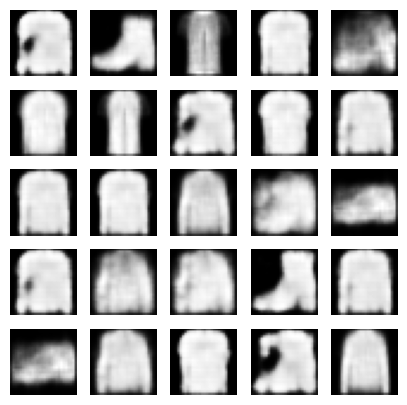

In [ ]:
# Generate a few random images
n = 25

plt.figure(figsize = (5, 5))

for i in np.arange(0, n, 1):
    plt.subplot(5, 5, i + 1)
    z_sample = np.array([[np.random.randn(), np.random.randn()]])
    X_new = vae.decoder.predict(z_sample).reshape(28, 28, 1)
    plt.imshow(X_new, cmap = 'gray')
    plt.axis('off')

As you can see above, the network is now able to generate new images similar to the ones that were used to train it from random latent space vectors. Let us now visualize the latent space by looking at their corresponding images.

### Visualizing the latent space with respect to the image space
In this section, we will look at the latent space vectors in terms of their corresponding decoded or generated images. Note that each unique random vector in the latent space corresponds to a unique image in the original image space.

1/1 [==============================] - 0s 24ms/step


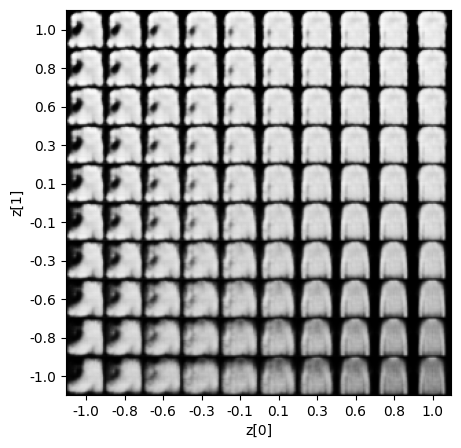

In [ ]:
# Plot the 2D latent space and visualize the corresponding images in the space for a fixed resolution
n_images = 10
figure_size = 5
figure = np.zeros((28 * n_images, 28 * n_images))
grid_x = np.linspace(-1, 1, n_images)
grid_y = np.linspace(-1, 1, n_images)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        X_new = vae.decoder.predict(z_sample)
        X_new = X_new[0].reshape(28, 28)
        figure[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = X_new

plt.figure(figsize = (figure_size, figure_size))
start_range = 28 // 2
end_range = n_images * 28 + start_range
pixel_range = np.arange(start_range, end_range, 28)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.imshow(figure, cmap = 'gray')

### Visualizing the actual latent space
We have a good understanding of the relationship between the latent space and the image space. In this section, we will visualize the latent space using the encoded versions of the original images.

In [ ]:
# Obtain the latent space vectors for each original image
z_mean, _, _ = vae.encoder.predict(X)

2188/2188 [==============================] - 8s 4ms/step


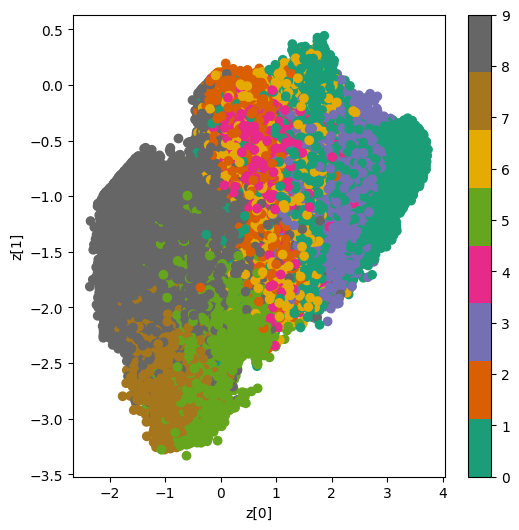

In [ ]:
# Plot the corresponding latent space vectors for each original image in a 2D plane
plt.figure(figsize = (6, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c = y, cmap = 'Dark2')
plt.colorbar()
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.show()

You can see that the original images form distinct clusters in the latent space. Each of these clusters contain similar images from the original set of images. For instance, one of these clusters might be shoes only, and another might be skirts only, and so on.